### Evaluating the forecast skill of GloFAS in Bangladesh

This notebook is to compare the forecast skill of GloFAS for various lead times. We are comparing the reforecast product (lead time 5-30 days) against the reanalysis product. This is an improvement on the ```process-glofas``` notebook and takes the processed GloFAS data created by ```get_glofas_data.py```. 

We're specifically interested in the forecast skill during times of potential flooding, here estimated to be between June - Oct. 

In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import sys
import pandas as pd
import xskillscore as xs

path_mod = f"{Path(os.path.dirname(os.path.realpath(''))).parents[1]}/"
sys.path.append(path_mod)

from src.indicators.flooding import glofas
from src.bangladesh import get_glofas_data

DATA_DIR = os.environ['AA_DATA_DIR']

# I've copied the processed data to my local aa directory because of this weird xarray file opening problem,
# but others would probably want to uncomment the line below to read from the GDrive
GLOFAS_DIR = os.path.join(path_mod, 'analyses', 'bangladesh', 'trigger_development', 'processed_data') 
#GLOFAS_DIR = os.path.join(DATA_DIR, 'processed', 'bangladesh', 'GloFAS_Data')

STATION = 'Bahadurabad'
LEADTIME_HOURS = [120, 240, 360, 480, 600, 720]

#### Read in and clean up the reforecast and reanalysis

The function below reads in the reforecast data based on an input lead time and station. This is read in directly from the processed ```.nc``` file, but in the future should make use of the existing ```get_glofas_data.py``` script. The data is also interpolated to a daily granularity and temporally shifted according to the forecast lead time. 

We'll read in the reforecast data according to the station and leadtime hours specified above. We'll also read in the reanalysis data to use as our proxy for historical observations. 

In [6]:
def process_rf(lt, station):
    t = xr.open_dataset(os.path.join(GLOFAS_DIR, f'bgd_cems-glofas-reforecast_0{lt}.nc'))[STATION]
    days = (t.time.max().values - t.time.min().values).astype('timedelta64[D]')
    days = days / np.timedelta64(1, 'D')
    t = t.interp(time=pd.date_range(t.time.min().values, t.time.max().values, periods=days+1), method='linear')
    t = t.shift(time=int(lt/24))
    t = t.rename({'number': 'member'}) # Rename to fit with xskillscore
    return t

rf_list = [process_rf(hour, STATION) for hour in LEADTIME_HOURS]
ra = xr.open_dataset(os.path.join(GLOFAS_DIR, 'bgd_cems-glofas-historical.nc'))[STATION]

Let's take a sample of some of the data to check that it all looks like we would expect. 

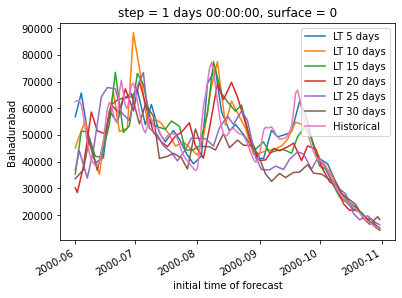

In [7]:
# Slice time and get mean of ensemble members for simple plotting
start = '2000-06-01'
end = '2000-10-31'
rf_list_slice = [da.sel(time=slice(start, end)) for da in rf_list]
rf_list_slice_mean = [da.mean(dim='member', keep_attrs=True) for da in rf_list_slice]
ra_slice = ra.sel(time=slice(start, end))

# Basic line plot to check that the data looks like we'd expect
for rf in rf_list_slice_mean:
    lt = rf[1].step.values/np.timedelta64(1, 'D')
    rf.plot.line(label=f'LT {int(lt)} days')
ra_slice.plot.line(label='Historical')
plt.legend()
plt.show()

#### Compute the measure(s) of forecast skill

We'll compute forecast skill using the ```xskillscore``` library and focus on the CRPS (continuous ranked probability score) value, which is similar to the mean absolute error but for probabilistic forecasts. This is also what GloFAS uses in evaluating their own forecast skill.

In [9]:
df_crps = pd.DataFrame(columns=['leadtime', 'crps', 'year'])
years = list(range(1999,2019))

for year in years:
    for rf in rf_list:
        start = str(year) + '-06-01'
        end = str(year) + '-10-30'
        rf_slice = rf.sel(time=slice(start, end))
        ra_slice = ra.sel(time=slice(start, end))
        crps_ensemble = xs.crps_ensemble(ra_slice, rf_slice)
        lt = rf_slice.step.values/np.timedelta64(1, 'D')
        df_crps = df_crps.append([{'leadtime':int(lt), 'crps':crps_ensemble.values.round(2), 'year': year}], ignore_index=True)

# Save results disaggregated by year
df_crps.to_csv(os.path.join(DATA_DIR, 'processed', 'bangladesh', 'GloFAS_Data', f'{STATION}_crps.csv'))

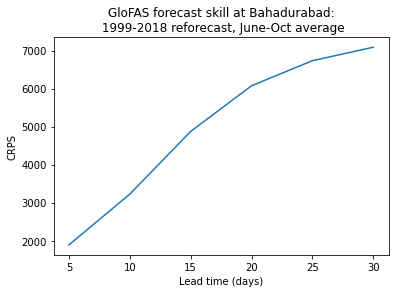

In [11]:
# Quick plot to summarize the results across all years
df_crps_avg = df_crps.groupby('leadtime').mean().reset_index()

plt.plot(df_crps_avg.leadtime, df_crps_avg.crps)
plt.title("GloFAS forecast skill at Bahadurabad:\n 1999-2018 reforecast, June-Oct average")
plt.xlabel("Lead time (days)")
plt.ylabel("CRPS")
plt.show()